# Predicting What Subreddit a Post Came From
---

### This notebook accomplishes the following:


---

### Prepare data for modeling

Things to do here:
* grab just the subreddit, selftext, and title
* binarize the subreddit column
* train_test_split
* countvectorize the title and selftext

In [1]:
# Imports
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC

### Read in the data files

In [2]:
df1 = pd.read_csv('../data/clean_dmacademy.csv')
df2 = pd.read_csv('../data/clean_truezelda.csv')

In [3]:
frames = [df1, df2]

In [4]:
text_df = pd.concat(frames, axis=0, ignore_index=True)

In [5]:
text_df

,subreddit,title,text
0,DMAcademy,Seeking seasoned DMs to be guests on interview...,Edit UPDATE Thank you for the robust respo...
1,DMAcademy,TERRAIN and Using it Effectively,TERRAIN and using it Effectively DM Tips Usi...
2,DMAcademy,Know the exact location of something,The players are planning on dropping an evil a...
3,DMAcademy,How to run military basic as a session,I am running a campaign for all intents and pu...
4,DMAcademy,Best time to take breaks how long they should be,Hey just a newbie DM My sessions are usually ...
...,...,...,...
8994,truezelda,What happened in the story of the missing link...,I don t really like playing games now but I am...
8995,truezelda,Do you think Blind The Thief is a Sheikah,We know that he lived in Kakariko Village
8996,truezelda,Should games such as Tri Force Heroes and Four...,The Zelda timeline is infamous for being convo...
8997,truezelda,Review score predictions for Skyward HD,Title says it all How will it fare With the o...


In [6]:
text_df.to_csv('../data/dmac_truz.csv', index=False)

In [7]:
text_df.isnull().sum()

subreddit    0
title        0
text         0
dtype: int64

Finally, replace those nulls with empty strings.

---
### Map our target variable to integer values

In [8]:
text_df.dtypes

subreddit    object
title        object
text         object
dtype: object

In [9]:
text_df['subreddit']

0       DMAcademy
1       DMAcademy
2       DMAcademy
3       DMAcademy
4       DMAcademy
          ...    
8994    truezelda
8995    truezelda
8996    truezelda
8997    truezelda
8998    truezelda
Name: subreddit, Length: 8999, dtype: object

In [10]:
# this step is optional
text_df['subreddit'] = text_df['subreddit'].map({'truezelda':1,'DMAcademy':0})

In [11]:
text_df['subreddit']

0       0
1       0
2       0
3       0
4       0
       ..
8994    1
8995    1
8996    1
8997    1
8998    1
Name: subreddit, Length: 8999, dtype: int64

---
### Create X and y

In [12]:
X = text_df['title'] + ' ' + text_df['text']
y = text_df['subreddit']

In [13]:
print(text_df['title'][0])
print(text_df['text'][0][:100])

print(X[0][:150])

Seeking seasoned DMs to be guests on interview podcast
  Edit  UPDATE  Thank you for the robust response I ve had some great applications so far and I m hy
Seeking seasoned DMs to be guests on interview podcast   Edit  UPDATE  Thank you for the robust response I ve had some great applications so far and I


Looks like it has what we want! 

### Establishing a baseline
In order to measure how good our models are doing, we have to compare our model accuracy to a **baseline**. 

In [14]:
y.value_counts(normalize=True)

0    0.54306
1    0.45694
Name: subreddit, dtype: float64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 42, 
                                                    stratify = y,
                                                    shuffle=True)

In [16]:
X_train

852     How do I balance NPC Fights Hey Guys I play Pe...
2798    How do I handle starting a campaign adventure ...
7450    What  Stal  enemy could ve also provided bone ...
8383    Zelda songs you just don t like I really like ...
1744    Homebrew Blacksmithing A player in my party is...
                              ...                        
7361    BoTW sequel information what and when  People ...
8212    Skyward Sword Switch port listed on Amazon in ...
7452    Why does anyone consider Ocarina of Time to be...
4498    Campaign Adventure Ideas Some backstory I m cu...
8734    After  years I finally got around to and beati...
Length: 6749, dtype: object

In [17]:
y_train.value_counts(normalize=True)

0    0.543043
1    0.456957
Name: subreddit, dtype: float64

Finally, on to the exciting part - the modeling! 

---
### Add custom stop words

In [18]:
custom_words = ['like', 'just', 've', 'don', 'll', 'game', 'games', 'a', 'b', 'c', 'd', 
                'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 
                's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'know', 'really', 'new', 'think',
               'things', 'want', 'make', 'way', 'feel', 'world', 'time']

In [19]:
from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS.union(custom_words)

### Combine GridSearchCV and Bernoulli Naive Bayes model

In [20]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_words)),
    ('nb', BernoulliNB())
])

In [21]:
pipe_params = {
    #'cvec__max_features':[2000, 3000, 4000, 5000],
    'cvec__min_df':[2, 3],
    'cvec__max_df':[.9, .95],
    # 'cvec__ngram_range':[(1, 1)], # default is best
    'nb__alpha':np.logspace(-3, 1, 20)
}

In [22]:
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5, n_jobs=-1, verbose=2)

In [23]:
%time gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

print('train accuracy:', gs.score(X_train, y_train))

print('test accuracy:', gs.score(X_test, y_test))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Wall time: 38.9 s
0.9899243884358784
{'cvec__max_df': 0.9, 'cvec__min_df': 3, 'nb__alpha': 0.0069519279617756054}
train accuracy: 0.9933323455326715
test accuracy: 0.9933333333333333


In [57]:
preds_cvec = gs.predict(X_test)

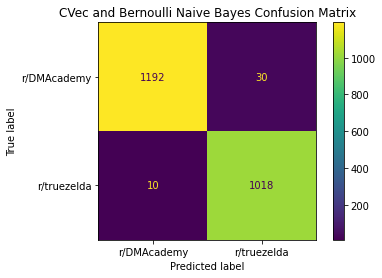

In [55]:
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm, display_labels=['r/DMAcademy','r/truezelda']).plot();
plt.title('CVec and Bernoulli Naive Bayes Confusion Matrix')
plt.savefig('../visualizations/bnb_cvec_confusion_matrix.png')

In [27]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1222
           1       1.00      0.99      0.99      1028

    accuracy                           0.99      2250
   macro avg       0.99      0.99      0.99      2250
weighted avg       0.99      0.99      0.99      2250



In [28]:
specificity = tn / (tn + fp)
print('specificity:', specificity)

specificity: 1.0


In [76]:
class_report_1 = pd.DataFrame(classification_report(y_test, preds_cvec, output_dict=True)).transpose()
class_report_1.drop(index=['macro avg', 'weighted avg'], columns=['support'], inplace=True)
# https://stackoverflow.com/questions/40427943/how-do-i-change-a-single-index-value-in-pandas-dataframe
class_report_1.rename(index={'0':'r/DMAcademy', '1':'r/truezelda'}, inplace=True)

print('CVec and Bernoulli NB Classification Report')
class_report_1

CVec and Bernoulli NB Classification Report


,precision,recall,f1-score
r/DMAcademy,0.987874,1.000000,0.993900
r/truezelda,1.000000,0.985409,0.992651
accuracy,0.993333,0.993333,0.993333


### TFIDF Vectorizer

In [89]:
pipe_tvec = Pipeline([
    ('vectorizer', TfidfVectorizer(), CountVectorizer()),
    ('nb', BernoulliNB())
])

In [90]:
pipe_tvec_params = {
    #'tvec__max_features': [2000, 3000, 4000, 5000],
    #'tvec__stop_words': [None, 'english'],
    'nb__alpha':np.logspace(-3, 1, 100)
}

In [91]:
gs_tvec = GridSearchCV(pipe_tvec, param_grid = pipe_tvec_params, cv=5, n_jobs=-1, verbose=2)

In [92]:
%time gs_tvec.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\users\derya\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


AttributeError: lower not found

In [93]:
print(gs.best_score_)
print(gs.best_params_)

0.9899243884358784
{'cvec__max_df': 0.9, 'cvec__min_df': 3, 'nb__alpha': 0.0069519279617756054}


In [94]:
gs_tvec.score(X_train, y_train)

AttributeError: 'GridSearchCV' object has no attribute 'scorer_'

In [ ]:
gs_tvec.score(X_test, y_test)

In [38]:
preds_tvec = gs_tvec.predict(X_test)

cm = confusion_matrix(y_test, preds_tvec)
tn, fp, fn, tp = cm.ravel()

specificity = tn / (tn + fp)
specificity

0.9983633387888707

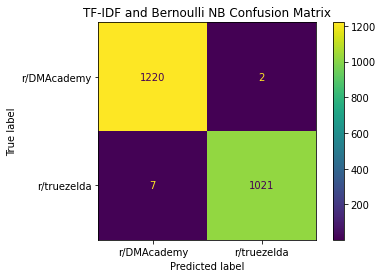

In [39]:
ConfusionMatrixDisplay(cm, display_labels=['r/DMAcademy','r/truezelda']).plot();
plt.title('TF-IDF and Bernoulli NB Confusion Matrix')
plt.savefig('../visualizations/bnb_tfidf_confusion_matrix.png')

In [75]:
class_report_1 = pd.DataFrame(classification_report(y_test, preds_tvec, output_dict=True)).transpose()
class_report_1.drop(index=['macro avg', 'weighted avg'], columns=['support'], inplace=True)
class_report_1.rename(index={'0':'r/DMAcademy', '1':'r/truezelda'}, inplace=True)
print('TF-IDF and Bernoulli NB Classification Report')
class_report_1

TF-IDF and Bernoulli NB Classification Report


,precision,recall,f1-score
r/DMAcademy,0.994295,0.998363,0.996325
r/truezelda,0.998045,0.993191,0.995612
accuracy,0.996000,0.996000,0.996000


In [40]:
print(classification_report(y_test, preds_tvec))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1222
           1       1.00      0.99      1.00      1028

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250



This model is better at classifying true negative, but has greater false negatives! Much higher specificity than the bernoulli naive bayes model.

### Create a Support Vector Machine (SVM) model

In [77]:
pipe = Pipeline([
    #('cvec', CountVectorizer()),
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
])

In [78]:
svc=SVC()
pipe_params = {
    #'cvec__max_features':[2000, 3000, 4000, 5000],
    #'cvec__min_df':[2, 3],
    #'cvec__max_df':[.9, .95],
    #'cvec__ngram_range':[(1, 1), (1, 2)],
    'svc__C': np.linspace(2, 1000, 40),
    #'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    #'degree':range(2,6),
    #'gamma':['scale', 'auto']
}

In [79]:
svc_gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5, n_jobs=-1, verbose=2)

In [80]:
SVC().get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [81]:
# Fit the model on training data

# This takes a few minutes to run so be sure about it! 
%time svc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Wall time: 6min 3s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': array([   2.        ,   27.58974359,   53.17948718,   78.76923077,
        104.35897436,  129.94871795,  155.53846154,  181.12820513,
        206.71794872,  232.30769231,  257.8974359 ,  283.48717949,
        309.07692308,  334.66666667,  360.25641026,  385.84615385,
        411.43589744,  437.02564103,  462.61538462,  488.20512821,
        513.79487179,  539.38461538,  564.97435897,  590.56410256,
        616.15384615,  641.74358974,  667.33333333,  692.92307692,
        718.51282051,  744.1025641 ,  769.69230769,  795.28205128,
        820.87179487,  846.46153846,  872.05128205,  897.64102564,
        923.23076923,  948.82051282,  974.41025641, 1000.        ])},
             verbose=2)

In [82]:
print(svc_gs.best_score_)
print(svc_gs.best_params_)
print('train accuracy:', svc_gs.score(X_train, y_train))
print('test accuracy:', svc_gs.score(X_test, y_test))

0.9902214534771986
{'svc__C': 2.0}
train accuracy: 1.0
test accuracy: 0.9933333333333333


In [83]:
preds_svc = svc_gs.predict(X_test)

In [84]:
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()

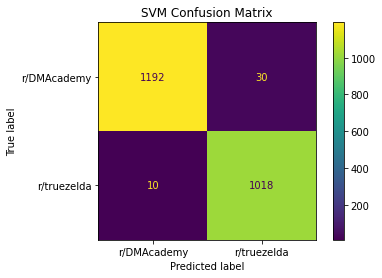

In [85]:
ConfusionMatrixDisplay(cm, display_labels=['r/DMAcademy','r/truezelda']).plot();
plt.title('SVM Confusion Matrix')
plt.savefig('../visualizations/svm_confusion_matrix.png')

In [86]:
class_report_1 = pd.DataFrame(classification_report(y_test, preds_svc, output_dict=True)).transpose()
class_report_1.drop(index=['macro avg', 'weighted avg'], columns=['support'], inplace=True)
class_report_1.rename(index={'0':'r/DMAcademy', '1':'r/truezelda'}, inplace=True)
print('CVec and SVM Classification Report')
class_report_1

CVec and SVM Classification Report


,precision,recall,f1-score
r/DMAcademy,0.991050,0.996727,0.993880
r/truezelda,0.996082,0.989300,0.992679
accuracy,0.993333,0.993333,0.993333


In [ ]:
#X = cvec.transform(X)

In [ ]:
X

In [ ]:
text_df['subreddit']

In [ ]:
results = pd.DataFrame(text_df['subreddit'])

In [ ]:
results.head()

In [ ]:
results['predicted'] = svc_gs.predict(X)

In [ ]:
results.head()

In [ ]:
mask = results['predicted']!=results['subreddit']
row_ids = results[mask].index

In [ ]:
results[mask].index

In [ ]:
print(f'The model guessed this was: {results["predicted"].iloc[38]}.')
print(f'This actually is: {results["subreddit"].iloc[38]}.')

In [ ]:
for index in row_ids[:5]:
    print(text_df['title'].iloc[index])
    print(text_df['selftext'].iloc[index])
    print(f'The model guessed this was: {results["predicted"].iloc[index]}.')
    print(f'This actually is: {results["subreddit"].iloc[index]}.')
    print('\n')
    